<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S11/resnet_model_album_cam__ocp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Colab and importing generic Packages
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,PadIfNeeded,
    Transpose, RandomCrop ,ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks\resnet')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/resnet')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#importing self-created packages:
import get_max_lr as t                                                         #import train - test module .This is class to train and evaluate the model
import load as ld                                                               #dataloader
import mod_summ as m                                                            #Getting model summary package
import resnet_s11 as bb                                                         #Getting Classes for Resnet and Basic Block
import s11_album as al                                                          #Getting albumentation module
import override_album as oa                                                     # overriding the albumentation class
import GradCm as gd                                                             #Grad Cam Module
import plot_cam   as pt                                                         #Plotting Image with Gradcam
import lr_update  as lr                                                         #exponential LR update
 


In [3]:
net=bb.Net().to('cuda') 
m.summ_print(net,(3,32,32))# Model summary.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

In [0]:
train_transforms,test_transforms=al.album_transform(albumentations)             #Albumentation class 

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=None)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = oa.PyTorchImageDataset(image=trainset, augmentations=train_transforms)
test_ds =  oa.PyTorchImageDataset(image=testset, augmentations=test_transforms)

In [0]:
batch_size=512
trainloader,testloader=ld.load_test_train(batch_size,train_ds,test_ds,torchvision,torch)

In [0]:
def range_test(end_lr=10,num_iter=100,step_mode="exp", smooth_f=0.05, diverge_th=5):
        if step_mode.lower() == "exp":
            lr_schedule = lr.ExponentialLR(optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = lr.LinearLR(optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")
        return lr_schedule

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_acc_graph=[]
history = {"lr": [], "loss": []}
getlr=0.0001
optimizer = optim.SGD(net.parameters(),lr=getlr)                               # start LR is 0.00001
lr_schedule=range_test(end_lr=1,num_iter=100,step_mode="linear",smooth_f=0.04,diverge_th=5)
criterion=nn.CrossEntropyLoss()
best_loss = None
diverge_th=50
num_iter=100
smooth_f=0.05
device='cuda'
EPOCHS =40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc1=t.train(net, device, trainloader, optimizer,train_losses,train_acc,tqdm,criterion)
    train_acc_graph.append(train_acc1)   
    lr_schedule.step()
    lrn=lr_schedule.get_lr()[0] 
    history["lr"].append(lrn)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.4425585269927979 Batch_id=97 Accuracy=34.90: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.9154690504074097 Batch_id=97 Accuracy=41.92: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 2


Loss=1.4745986461639404 Batch_id=97 Accuracy=47.10: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 3


Loss=1.5885627269744873 Batch_id=97 Accuracy=51.10: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 4


Loss=1.2711541652679443 Batch_id=97 Accuracy=56.43: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 5


Loss=0.9513278007507324 Batch_id=97 Accuracy=59.61: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 6


Loss=1.5518579483032227 Batch_id=97 Accuracy=59.28: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 7


Loss=2.7582249641418457 Batch_id=97 Accuracy=59.59: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 8


Loss=1.2134469747543335 Batch_id=97 Accuracy=63.90: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 9


Loss=1.0232141017913818 Batch_id=97 Accuracy=65.13: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 10


Loss=1.0433588027954102 Batch_id=97 Accuracy=70.24: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 11


Loss=0.9655817151069641 Batch_id=97 Accuracy=61.85: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 12


Loss=0.6920813918113708 Batch_id=97 Accuracy=72.72: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 13


Loss=1.1596729755401611 Batch_id=97 Accuracy=67.10: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 14


Loss=0.7995172142982483 Batch_id=97 Accuracy=64.72: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 15


Loss=0.9536188244819641 Batch_id=97 Accuracy=66.71: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 16


Loss=1.2579736709594727 Batch_id=97 Accuracy=71.27: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 17


Loss=1.9244966506958008 Batch_id=97 Accuracy=49.94: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 18


Loss=1.372096061706543 Batch_id=97 Accuracy=50.99: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 19


Loss=1.4386916160583496 Batch_id=97 Accuracy=64.07: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 20


Loss=1.190610647201538 Batch_id=97 Accuracy=68.96: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 21


Loss=0.6809561848640442 Batch_id=97 Accuracy=72.11: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 22


Loss=1.4493827819824219 Batch_id=97 Accuracy=63.68: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 23


Loss=1.0663323402404785 Batch_id=97 Accuracy=67.75: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 24


Loss=1.2151674032211304 Batch_id=97 Accuracy=73.30: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 25


Loss=0.544440746307373 Batch_id=97 Accuracy=77.70: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 26


Loss=0.6788622140884399 Batch_id=97 Accuracy=80.75: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 27


Loss=0.4855095446109772 Batch_id=97 Accuracy=82.37: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 28


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 29


Loss=0.4385439455509186 Batch_id=97 Accuracy=85.85: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 30


Loss=0.526889979839325 Batch_id=97 Accuracy=82.07: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 31


Loss=0.36185431480407715 Batch_id=97 Accuracy=86.43: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 32


Loss=0.2394268810749054 Batch_id=97 Accuracy=88.57: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 33


Loss=0.44747602939605713 Batch_id=97 Accuracy=89.47: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 34


Loss=0.21012505888938904 Batch_id=97 Accuracy=90.47: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 35


Loss=0.24902911484241486 Batch_id=97 Accuracy=91.05: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 36


Loss=1.0337415933609009 Batch_id=97 Accuracy=90.46: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 37


Loss=1.5925993919372559 Batch_id=97 Accuracy=37.03: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 38


Loss=0.8503304719924927 Batch_id=97 Accuracy=63.43: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 39


Loss=0.6658252477645874 Batch_id=97 Accuracy=76.82: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]


0.090091

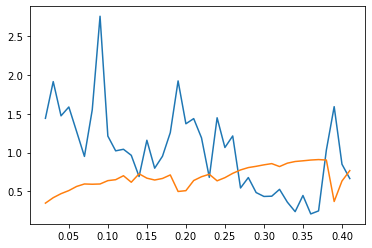

In [10]:
max_lr1=history['lr'][train_acc_graph.index(max(train_acc_graph))]  
plt.plot(history['lr'],train_acc_graph)
net1=bb.Net().to('cuda')      
max_lr1                                                  # Creating new model for final training.

In [11]:
import train_test_model_resnet18_missclass as t1                                   #import train - test module .This is class to train and evaluate the model
train_losses = []
test_acc = []
test_losses = []
train_acc = []
train_loss_graph=[]
train_acc_graph=[]
test_acc_graph=[]
test_loss_graph=[]
EPOCHS = 24
optimizer = optim.SGD(net1.parameters(),lr=0.0001,weight_decay=0.0020,momentum=0.90)
criterion=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr1,steps_per_epoch=len(trainloader),pct_start=0.208,epochs=24,div_factor=10,anneal_strategy='linear')

device='cuda'
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_loss,train_acc1=t1.train(net1, device, trainloader, optimizer, epoch,train_losses,train_acc,tqdm,criterion)
    train_loss_graph.append(train_loss)
    train_acc_graph.append(train_acc1)
    test_loss,test_acc1=t1.test(net1, device, testloader,test_losses,test_acc,tqdm,criterion,torch)
    test_loss_graph.append(test_loss)    
    test_acc_graph.append(test_acc1)
    scheduler.step(test_loss)
    

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.3790595531463623 Batch_id=97 Accuracy=22.57: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 2511/10000 (25.11%)

EPOCH: 1


Loss=1.7202428579330444 Batch_id=97 Accuracy=33.92: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 4088/10000 (40.88%)

EPOCH: 2


Loss=1.5542553663253784 Batch_id=97 Accuracy=42.51: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 4545/10000 (45.45%)

EPOCH: 3


Loss=1.4757274389266968 Batch_id=97 Accuracy=47.98: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5191/10000 (51.91%)

EPOCH: 4


Loss=1.6214845180511475 Batch_id=97 Accuracy=54.56: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5466/10000 (54.66%)

EPOCH: 5


Loss=1.1881459951400757 Batch_id=97 Accuracy=59.18: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 5991/10000 (59.91%)

EPOCH: 6


Loss=0.9795501232147217 Batch_id=97 Accuracy=65.44: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6700/10000 (67.00%)

EPOCH: 7


Loss=0.8548843860626221 Batch_id=97 Accuracy=69.46: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6842/10000 (68.42%)

EPOCH: 8


Loss=0.7880063652992249 Batch_id=97 Accuracy=73.03: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7134/10000 (71.34%)

EPOCH: 9


Loss=0.7218503952026367 Batch_id=97 Accuracy=76.99: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7350/10000 (73.50%)

EPOCH: 10


Loss=0.5183370113372803 Batch_id=97 Accuracy=80.06: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7907/10000 (79.07%)

EPOCH: 11


Loss=0.5039488673210144 Batch_id=97 Accuracy=82.14: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7899/10000 (78.99%)

EPOCH: 12


Loss=0.40771085023880005 Batch_id=97 Accuracy=84.15: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8010/10000 (80.10%)

EPOCH: 13


Loss=0.46498265862464905 Batch_id=97 Accuracy=86.14: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8100/10000 (81.00%)

EPOCH: 14


Loss=0.3531228005886078 Batch_id=97 Accuracy=87.66: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8219/10000 (82.19%)

EPOCH: 15


Loss=0.37406688928604126 Batch_id=97 Accuracy=89.18: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8305/10000 (83.05%)

EPOCH: 16


Loss=0.3100341856479645 Batch_id=97 Accuracy=90.04: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8337/10000 (83.37%)

EPOCH: 17


Loss=0.2752862870693207 Batch_id=97 Accuracy=91.04: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8386/10000 (83.86%)

EPOCH: 18


Loss=0.2526657283306122 Batch_id=97 Accuracy=91.84: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8313/10000 (83.13%)

EPOCH: 19


Loss=0.2579788565635681 Batch_id=97 Accuracy=92.53: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8371/10000 (83.71%)

EPOCH: 20


Loss=0.31757476925849915 Batch_id=97 Accuracy=93.22: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8362/10000 (83.62%)

EPOCH: 21


Loss=0.18325696885585785 Batch_id=97 Accuracy=93.83: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8419/10000 (84.19%)

EPOCH: 22


Loss=0.17167401313781738 Batch_id=97 Accuracy=94.57: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8507/10000 (85.07%)

EPOCH: 23


Loss=0.14634311199188232 Batch_id=97 Accuracy=95.38: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.0009, Accuracy: 8553/10000 (85.53%)



In [0]:
plt.plot(test_acc_graph)                
plt.plot(train_acc_graph)
plt.plot(test_loss_graph)
plt.plot(train_loss_graph)       
plt.title("Model Graph")            
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['test','train','test_loss','train_loss'] ,loc='upper left')
plt.show()  
plt.savefig('Upload_graph.png')           

In [0]:
cam2=[]
data2=[]
k=[]
dat=[]
number=0
p=[]
l=[]
data2=[]
for im in range(25):
  
  dat1,label = next(iter(testloader))
  dat1=dat1.to('cuda')
  output=net(dat1)
  pred = output.argmax(dim=1, keepdim=True)
  
  for i in range(label.size()[0]):
   if pred[i].item() != label[i].item():
    p.append(pred[i].item()) 
    l.append(label[i].item()) 
    label1=label[i]
    data1=dat1[i]
    data2.append(dat1[i].to('cpu'))
    label1=label1.unsqueeze(0) 
    Gd1=gd.GradCm()
    cam1=Gd1.img(data1,label1,net)
    cam2.append(cam1) 
    number = len(cam2)
    if number >= 25:
        print(number)
        break
  else:
   continue
  break 

In [0]:
plott=pt.Plot()
#l=l.to('cpu')
#data2=data2.to('cpu')
plott.fig(data2,cam2,l,p)


fgfghfhfgfhhggdrfrrfdsvfgdffdv          